In [ ]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics 
import scipy.io as spio
from nilearn.input_data import MultiNiftiMasker
from datetime import datetime

from sklearn.metrics import make_scorer,roc_auc_score,f1_score
from sklearn.model_selection import StratifiedKFold
import os
from joblib import dump, load

#location of images
absolute_path = '/home/kadajji/hydra-work/unmodulated_segments/2mm/'
mask = '/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/temp/GM_mask.nii'



#### modify the path here
regex_filter = 'wp1_*'
delcode_cov = '/home/kadajji/hydra-work/delcode_cov1079.mat'

#These are the locations where the files will be saved
path_AD_visualization = '/home/kadajji/Desktop/clf_AD_weights_sMRI_single_subject_withBootstrap_final.nii'
path_SCD_visualization = '/home/kadajji/Desktop/clf_SCD_weights_sMRI_single_subject_withBootstrap_final.nii'
path_MCI_visualization = '/home/kadajji/Desktop/clf_MCI_weights_sMRI_single_subject_withBootstra_final.nii'




# reading nifti files form the subjs folder
def read_nifti(absolute_path, regex_filter, smooth=None, mask=None):
    mask=mask
    smooth=4
    start_time = datetime.now()
    regex_filter = str(regex_filter)
    # mask images and get data
    data_folder = str(absolute_path)
    if(mask==None):
        niftimasker = MultiNiftiMasker(smoothing_fwhm=smooth, n_jobs=-2)
    else:
        niftimasker = MultiNiftiMasker(smoothing_fwhm=4, n_jobs=-2, mask_img=mask)
    list_path = []
    subjs = []
    i = 0
    for files in os.listdir(data_folder):
         if re.match(regex_filter, files):
             image_path = data_folder + files
             list_path.append(image_path)
             subject_name = os.path.basename(files).split('_')[3]
             subject_name = os.path.basename(subject_name).split('.')[0]
             subjs.append(subject_name)
    print("Reading "+ regex_filter +" volume data please wait.........")
    list_path = np.sort(list_path)
    subjs = np.sort(subjs)
    x = niftimasker.fit_transform(list_path)
    x = np.vstack(x)
    subjects_id = pd.DataFrame()
    subjects_id['subjs'] = subjs
    data_matrix = pd.DataFrame(x, dtype='float64')
    end_time = datetime.now()
    time = end_time - start_time
    print("Total time in minutes :", float(time.total_seconds() / 60))
    return data_matrix, subjects_id, niftimasker


# code to split train and test dataset
def train_test_split(dataset,random,split=0.75):
     train = dataset.sample(frac=split, random_state=random)
     test = dataset.drop(train.index)
     return train, test
 
    
# load delcode_cov
def get_data_mat(mat_url):
     dat = spio.loadmat(mat_url, squeeze_me=True)
     demo = dat['Demo']
     body = dat['Body']
     gen = dat['Gen']
     csf = dat['Csf']
     cog = dat['Cog']
     vol = dat['Vol']
     cog = cog['X'][()]
     csf = csf['X'][()]
     apoe = gen['apoe'][()]['X'][()]
     apoe = pd.DataFrame(apoe)
     apoe4 = ((apoe[0] == 4) + (apoe[1] == 4)) > 0
     delcode_data = pd.DataFrame()
     delcode_data['subjs'] = dat['IDs'][()]
     delcode_data['id'] = demo['IDn'][()]
     delcode_data['age'] = demo['age_bl'][()]
     delcode_data['bmi'] = body['bmi'][()]
     delcode_data['diag'] = demo['diag_bl'][()]
     delcode_data['sex'] = demo['sex'][()]
     delcode_data['apoe'] = apoe4
     delcode_data['edu'] = demo['edu'][()]
     delcode_data['fmem'] = cog[:,21]
     delcode_data['ptau'] = csf[:,4]
     delcode_data['abeta4240'] = csf[:,5]
     return delcode_data



In [ ]:
def norm(x):
    return (x-x.mean())/(x.std())

# read data by feature (GM brain tissue types)
data1, sub1, niftimasker =  read_nifti(absolute_path,regex_filter,mask=None)
data1 = norm(data1)
data1 = data1.replace(np.nan, 0)
print(data1)

Reading wp1_* volume data please wait.........
Total time in minutes : 1.5395054666666668
       0         1         2         3         4         5         6       \
0   -0.695977  0.229304 -0.744006 -0.870734  1.558230  2.544165 -0.643330   
1   -0.170406  0.035736 -0.661141 -0.870734 -0.210029  0.460321  0.467715   
2   -0.433191  1.648806  2.860651  1.512757  0.096016 -0.679896  3.389350   
3   -0.695977 -0.190094 -0.744006  1.070109  0.266041 -0.837167  0.056217   
4   -0.695977 -0.674015 -0.744006  0.389111 -0.890128 -0.090129 -0.643330   
..        ...       ...       ...       ...       ...       ...       ...   
970 -0.695977 -0.674015  1.451934 -0.564285 -0.924133 -0.679896 -0.314131   
971 -0.695977 -0.544970 -0.536842 -0.870734 -0.482069 -0.758531 -0.643330   
972 -0.695977 -0.674015  0.954740  1.342508  0.470071  0.224414 -0.643330   
973 -0.695977 -0.674015 -0.329678 -0.870734  0.198031  0.892817 -0.026083   
974 -0.695977 -0.674015  1.161904 -0.870734 -0.550079 -0.522624

In [ ]:

# reading subjects covariate data
delcode_data = get_data_mat(delcode_cov)
sub1['age'] = sub1.subjs.map(delcode_data.set_index('subjs')['age'])
sub1['edu'] = sub1.subjs.map(delcode_data.set_index('subjs')['edu'])
sub1['sex'] = sub1.subjs.map(delcode_data.set_index('subjs')['sex'])
sub1['diag'] = sub1.subjs.map(delcode_data.set_index('subjs')['diag'])
sub1['fmem'] = sub1.subjs.map(delcode_data.set_index('subjs')['fmem'])
sub1['apoe'] = sub1.subjs.map(delcode_data.set_index('subjs')['apoe'])
sub1['apoe'] = sub1['apoe'].map({True:1, False:0})    


   
subjects  = sub1[['subjs', 'age', 'sex', 'edu', 'fmem', 'diag', ]]
#excluded few subjects because of inconsistency in T1w images
exclude_subjects = ['0588be6c5', '0901942a8', '0c1c5ae77', '0df733308', '0e27a6de5', '0e3cd430b', '14136a5ce', '16cf80a1a', '19f47ee32', '1ad67792f', '1d48057fd', '1ece6ef85', '1eebab647', '1ef92e9c3', '3125073f4', '3300076e2', '3a018fc24', '4210b3c88', '46c3433d4', '475b9bfe2', '503be410d', '5659a73f6', '5b8721c3f', '5cbfe44a2', '625c4e8e1', '682305c91', '6b8442bc7', '6c06ac657', '6dc95ea8c', '72984fc3b', '74d781eee', '766b96f80', '781929efb', '7a3350a22', '7c86c18fc', '7e74ee245', '85eb9b1a2', '8e66edf5e', '9489a87de', '999bf662e', '9c8c5c08c', 'a5cceacea', 'a9b3982d2', 'ad0d19af0', 'ad73d5585', 'b093bca1e', 'b393e08ba', 'bbb5dedd3', 'c88ff511b', 'cd3bf904f', 'd23ebb73d', 'd310d786d', 'd4c29fe4b', 'd7af42c4d', 'e49cecc8c', 'e7967bcd4', 'eb95738e8', 'ee19c801d', 'f0c51137c', 'f2a767eaa', 'f30441648', 'f4ba91dc6', 'fa890e12f', 'ffa620116', 'fff6c90a3']
subjects = subjects[~subjects['subjs'].isin(exclude_subjects)]

subjects = subjects.dropna()

con5 = pd.DataFrame(data1, index=subjects.index)
con5 = pd.DataFrame(np.array(con5))
subjects.index  = con5.index
    

/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [ ]:
print(len(subjects))

907


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def create_confusion_matrix(test_label ,prediction, classifier):
    print(np.unique(test_label,return_counts=True))
    cm = confusion_matrix(test_label, prediction, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classifier.classes_)
    disp.plot()

    plt.show()

In [ ]:

def plotting_roc_auc_curve(test_label, predict_test_prob):
    probs = predict_test_prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(test_label, probs)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.grid()
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
def train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag):
    
    param_grid = {'C': [i for i in np.arange(0.00001,.01,0.001)],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['linear']}

    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
    # fitting the model for grid search
    grid.fit(X_train_diag, Y_train_diag.diag)

    # print best parameter after tuning
    print(grid.best_params_)
    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)

    # input the best params for c=0.001 & gamma=1   
    clf = svm.SVC(kernel='linear', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)
    scores = cross_val_score(clf, X_train_diag, Y_train_diag.diag, cv=5, scoring='f1_weighted')
    fit = clf.fit(X_train_diag, Y_train_diag.diag)

    predict_test_prob = clf.predict_proba(X_test_diag)

    probs = predict_test_prob[:,1]

    fpr, tpr, threshold = metrics.roc_curve(Y_test_diag.diag, probs)
    roc_auc = metrics.auc(fpr, tpr)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    y_pred = (probs > threshold[ix]).astype('float')

    create_confusion_matrix(Y_test_diag.diag,y_pred,clf)
    plotting_roc_auc_curve(Y_test_diag.diag,predict_test_prob)
    confusion =  metrics.confusion_matrix(Y_test_diag.diag, y_pred)
    TP, TN, FP, FN = confusion[1, 1], confusion[0, 0],confusion[0, 1],confusion[1, 0]
    specificity = (TN / (TN + FP))
    sensitivity = (TP / float(FN + TP))
    
    print(" F1 score on test set ---- " , f1_score(Y_test_diag.diag, y_pred, average='weighted'))
    print("weighted roc auc on test set", roc_auc_score(Y_test_diag.diag,clf.predict_proba(X_test_diag)[:, 1],average='weighted'))
    print("cross validation scores", scores)
    print("Specifity and sensitivity", specificity,sensitivity)
    return clf


In [ ]:
def create_train_test(subjects,con5,disease,random):
    
    subjects_cn_mci = subjects[(subjects['diag'] ==0) | (subjects['diag']==disease)]
    subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})
    data_cn_mci = pd.DataFrame(con5, index=subjects_cn_mci.index)
    Y_train_diag, Y_test_diag = train_test_split(subjects_cn_mci, random,0.75)
    X_train_diag, X_test_diag = pd.DataFrame(data_cn_mci, index=Y_train_diag.index), pd.DataFrame(con5, index=Y_test_diag.index)
    return Y_train_diag, Y_test_diag,X_train_diag, X_test_diag

0
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.6s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.5s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.8s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   5.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.7s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.7s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.6s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.6s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.5s
[CV 2/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 3/5] END .............C=

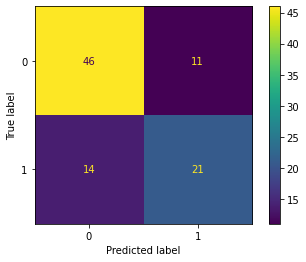

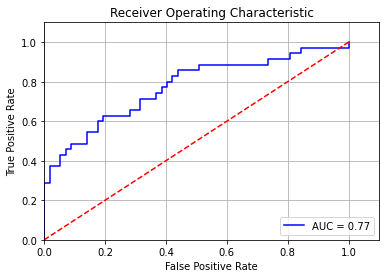

 F1 score on test set ----  0.7256609926953859
weighted roc auc on test set 0.7724310776942356
cross validation scores [0.74545455 0.79703075 0.78181818 0.65611964 0.75254965]
Specifity and sensitivity 0.8070175438596491 0.6
1


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.6s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

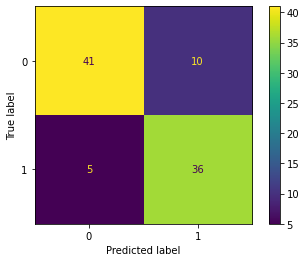

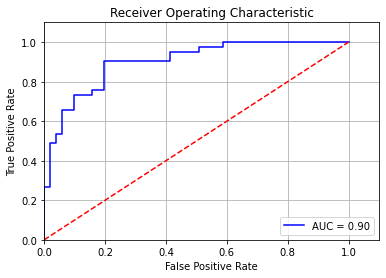

 F1 score on test set ----  0.8374395276588511
weighted roc auc on test set 0.9000478240076518
cross validation scores [0.72890515 0.73456183 0.65144948 0.65405405 0.82794062]
Specifity and sensitivity 0.803921568627451 0.8780487804878049
2


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.6s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

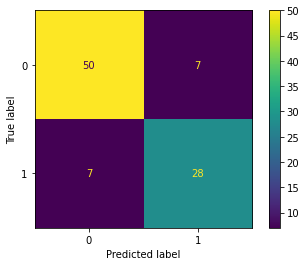

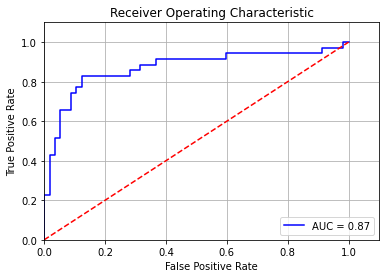

 F1 score on test set ----  0.8478260869565217
weighted roc auc on test set 0.8696741854636592
cross validation scores [0.68197905 0.76265186 0.77480519 0.7494598  0.75254965]
Specifity and sensitivity 0.8771929824561403 0.8
3


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

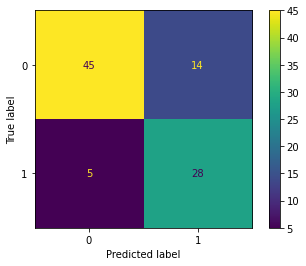

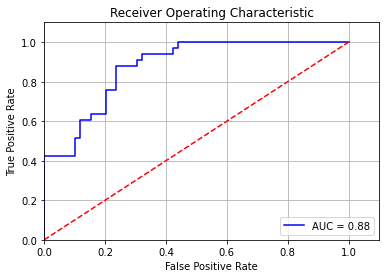

 F1 score on test set ----  0.7973434383725567
weighted roc auc on test set 0.87673343605547
cross validation scores [0.77480519 0.72908547 0.75407597 0.77097289 0.7201319 ]
Specifity and sensitivity 0.7627118644067796 0.8484848484848485
4


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

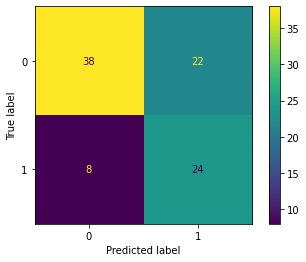

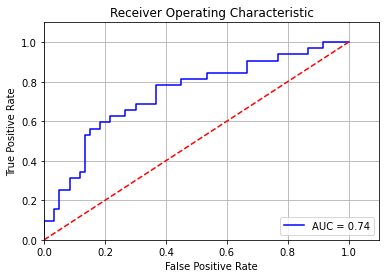

 F1 score on test set ----  0.6816432132264781
weighted roc auc on test set 0.7380208333333333
cross validation scores [0.81680441 0.76282828 0.86957807 0.72386482 0.67544015]
Specifity and sensitivity 0.6333333333333333 0.75
5


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

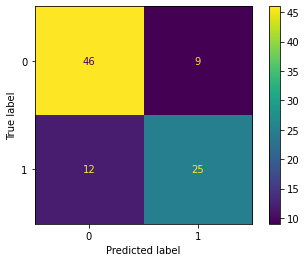

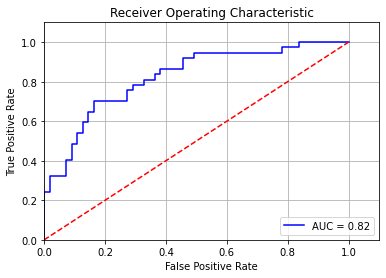

 F1 score on test set ----  0.7699467292403904
weighted roc auc on test set 0.8226044226044226
cross validation scores [0.62164502 0.7247678  0.71939328 0.77714286 0.82868822]
Specifity and sensitivity 0.8363636363636363 0.6756756756756757
6


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

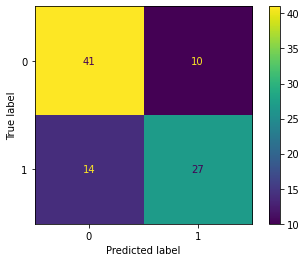

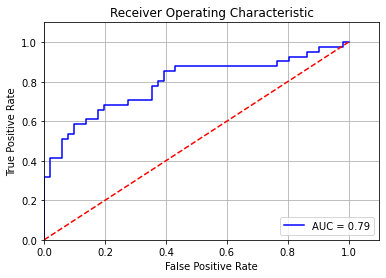

 F1 score on test set ----  0.737363538840159
weighted roc auc on test set 0.792443806791009
cross validation scores [0.76171329 0.77639553 0.57399381 0.77983193 0.80303833]
Specifity and sensitivity 0.803921568627451 0.6585365853658537
7


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

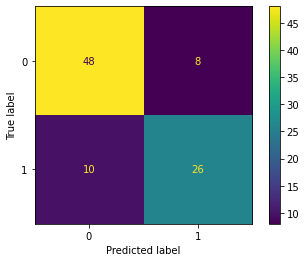

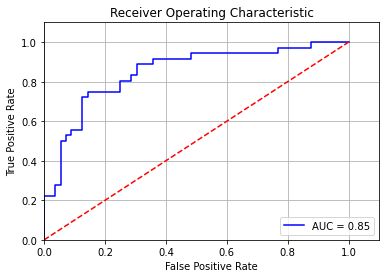

 F1 score on test set ----  0.803269042170644
weighted roc auc on test set 0.8492063492063492
cross validation scores [0.67649019 0.64941676 0.72322375 0.7328017  0.84650515]
Specifity and sensitivity 0.8571428571428571 0.7222222222222222
8


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.6s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

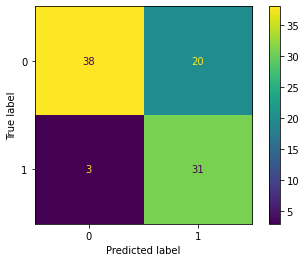

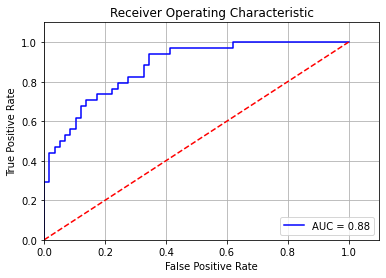

 F1 score on test set ----  0.7535353535353535
weighted roc auc on test set 0.8762677484787018
cross validation scores [0.73093093 0.69463052 0.67840704 0.65645933 0.84880174]
Specifity and sensitivity 0.6551724137931034 0.9117647058823529
9


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

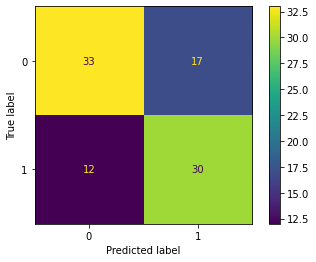

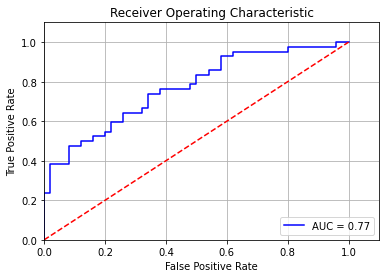

 F1 score on test set ----  0.6853418352916978
weighted roc auc on test set 0.768095238095238
cross validation scores [0.82361275 0.73456183 0.78933333 0.76246666 0.75146978]
Specifity and sensitivity 0.66 0.7142857142857143
10


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

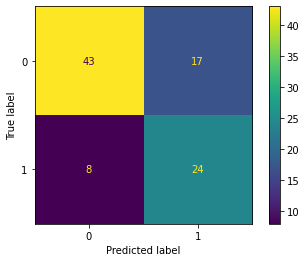

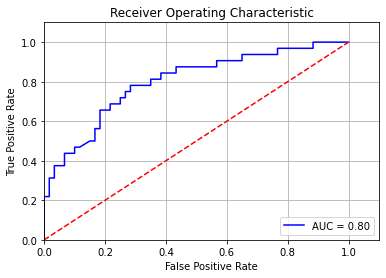

 F1 score on test set ----  0.7339954606184504
weighted roc auc on test set 0.7994791666666666
cross validation scores [0.76282828 0.67840704 0.75778785 0.72052444 0.81160814]
Specifity and sensitivity 0.7166666666666667 0.75
11


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

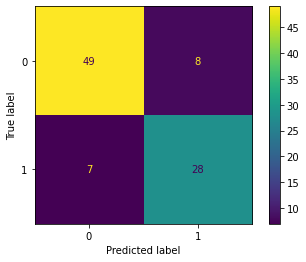

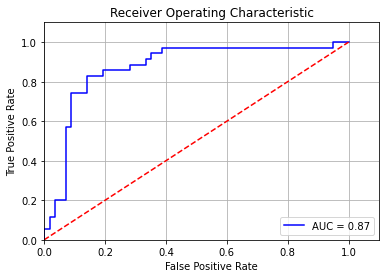

 F1 score on test set ----  0.8373832839282713
weighted roc auc on test set 0.8716791979949875
cross validation scores [0.76444444 0.74742857 0.65611964 0.78181818 0.72633745]
Specifity and sensitivity 0.8596491228070176 0.8
12


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

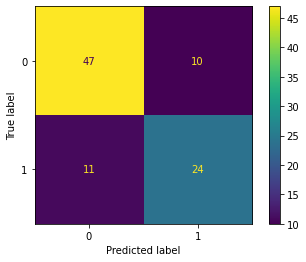

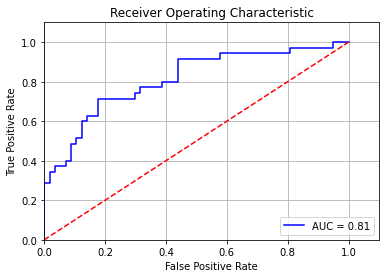

 F1 score on test set ----  0.771077504725898
weighted roc auc on test set 0.8105263157894737
cross validation scores [0.70285714 0.68544892 0.83231466 0.70688705 0.77320261]
Specifity and sensitivity 0.8245614035087719 0.6857142857142857
13


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

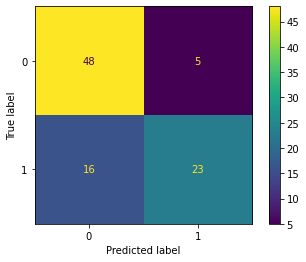

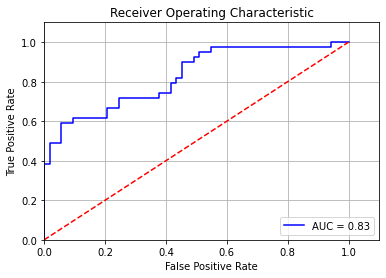

 F1 score on test set ----  0.7637315096757018
weighted roc auc on test set 0.8258345428156748
cross validation scores [0.72890515 0.83568205 0.73093093 0.7247678  0.63676352]
Specifity and sensitivity 0.9056603773584906 0.5897435897435898
14


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

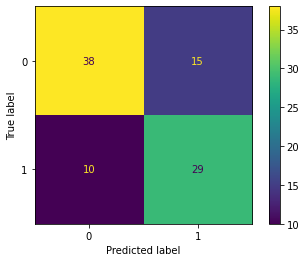

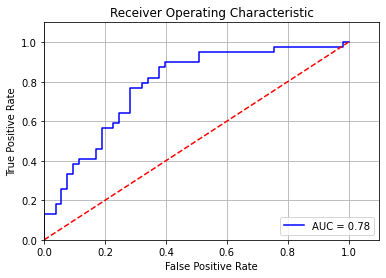

 F1 score on test set ----  0.7297195670326593
weighted roc auc on test set 0.7803580067731012
cross validation scores [0.72199883 0.75261014 0.68544892 0.74545455 0.78569254]
Specifity and sensitivity 0.7169811320754716 0.7435897435897436
15


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

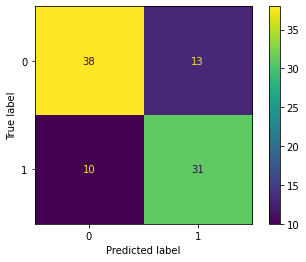

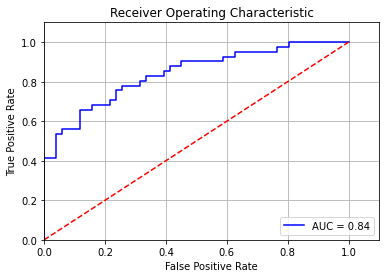

 F1 score on test set ----  0.7506238859180037
weighted roc auc on test set 0.8412242945958871
cross validation scores [0.75576049 0.65872236 0.63181818 0.70857143 0.81613005]
Specifity and sensitivity 0.7450980392156863 0.7560975609756098
16


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

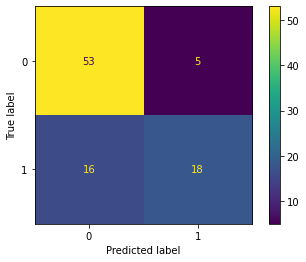

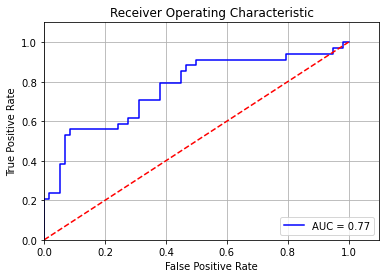

 F1 score on test set ----  0.759599272058956
weighted roc auc on test set 0.7682555780933062
cross validation scores [0.69249249 0.78016529 0.74545455 0.80914407 0.5934949 ]
Specifity and sensitivity 0.9137931034482759 0.5294117647058824
17


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

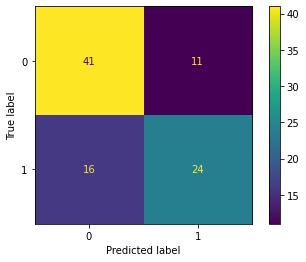

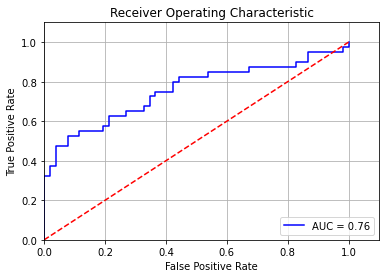

 F1 score on test set ----  0.7034702832070204
weighted roc auc on test set 0.7557692307692309
cross validation scores [0.74112554 0.71182796 0.81366295 0.7933358  0.82794062]
Specifity and sensitivity 0.7884615384615384 0.6
18


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.2s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

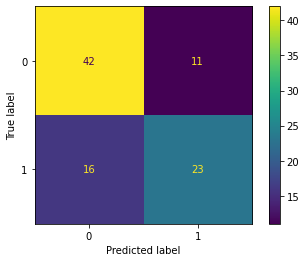

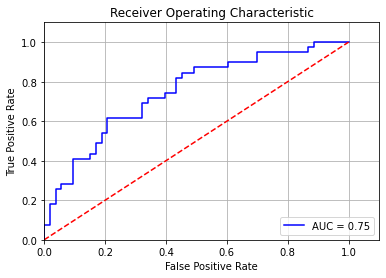

 F1 score on test set ----  0.703080984498495
weighted roc auc on test set 0.7460087082728591
cross validation scores [0.81428571 0.74       0.71455017 0.73912812 0.76851852]
Specifity and sensitivity 0.7924528301886793 0.5897435897435898
19


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

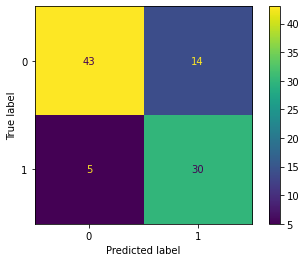

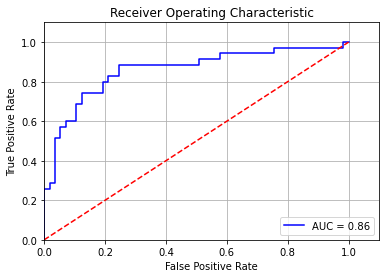

 F1 score on test set ----  0.7963912257252929
weighted roc auc on test set 0.8586466165413534
cross validation scores [0.70644258 0.65405405 0.70379424 0.81680441 0.73138402]
Specifity and sensitivity 0.7543859649122807 0.8571428571428571
20


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

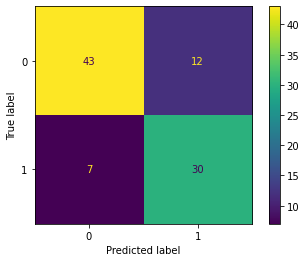

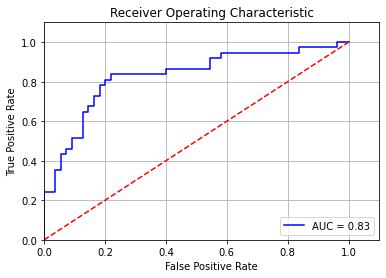

 F1 score on test set ----  0.7950965746783029
weighted roc auc on test set 0.828992628992629
cross validation scores [0.70857143 0.74742857 0.77983193 0.69196581 0.78706876]
Specifity and sensitivity 0.7818181818181819 0.8108108108108109
21


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

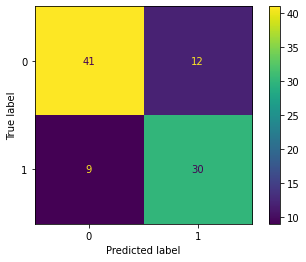

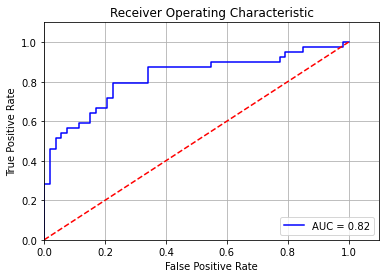

 F1 score on test set ----  0.7726419961540266
weighted roc auc on test set 0.8209966134494436
cross validation scores [0.76171329 0.71939328 0.81140351 0.75261014 0.70065359]
Specifity and sensitivity 0.7735849056603774 0.7692307692307693
22


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

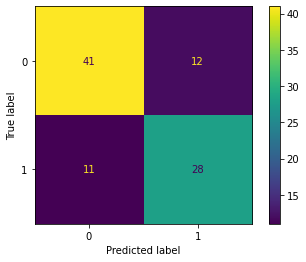

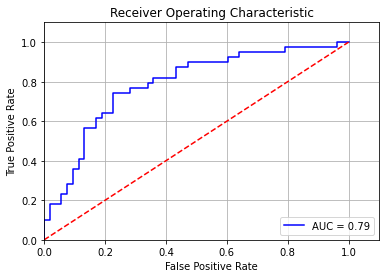

 F1 score on test set ----  0.7503918022905366
weighted roc auc on test set 0.7851959361393324
cross validation scores [0.7933358  0.79067012 0.74742857 0.74742857 0.77243108]
Specifity and sensitivity 0.7735849056603774 0.717948717948718
23


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

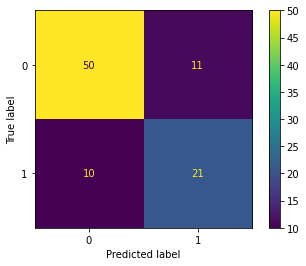

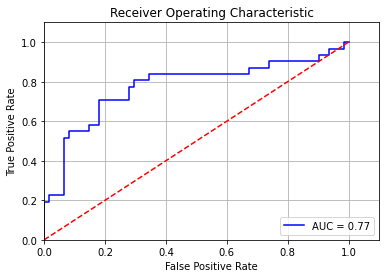

 F1 score on test set ----  0.7726074979039406
weighted roc auc on test set 0.7747223691168693
cross validation scores [0.70688705 0.75407597 0.75778785 0.71308973 0.77091503]
Specifity and sensitivity 0.819672131147541 0.6774193548387096
24


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

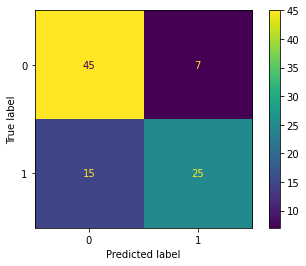

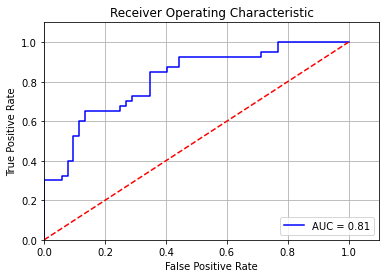

 F1 score on test set ----  0.7561249137336093
weighted roc auc on test set 0.8134615384615386
cross validation scores [0.74313725 0.68197905 0.80636082 0.74272727 0.78569254]
Specifity and sensitivity 0.8653846153846154 0.625
25


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

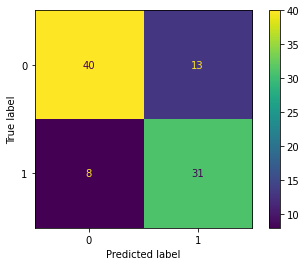

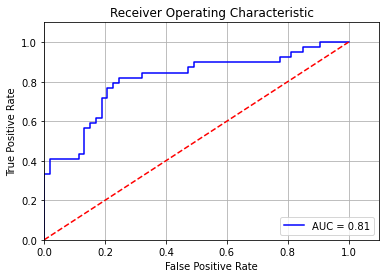

 F1 score on test set ----  0.7729644363074339
weighted roc auc on test set 0.8098693759071118
cross validation scores [0.73596491 0.78181818 0.71939328 0.76171329 0.76851852]
Specifity and sensitivity 0.7547169811320755 0.7948717948717948
26


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

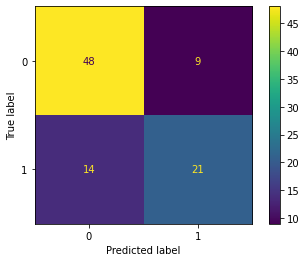

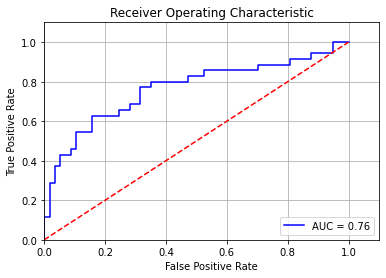

 F1 score on test set ----  0.7456367162249514
weighted roc auc on test set 0.762907268170426
cross validation scores [0.77714286 0.72322375 0.72063045 0.76282828 0.88660131]
Specifity and sensitivity 0.8421052631578947 0.6
27


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.5s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

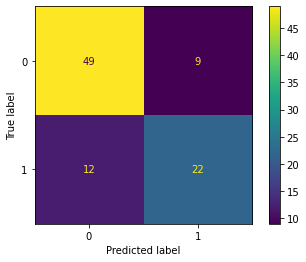

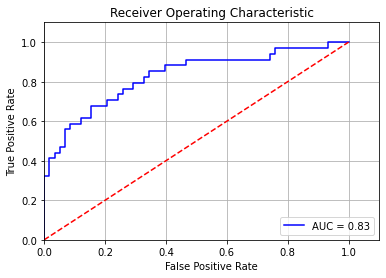

 F1 score on test set ----  0.7693488097580168
weighted roc auc on test set 0.8286004056795132
cross validation scores [0.68326103 0.78016529 0.75778785 0.67649019 0.73138402]
Specifity and sensitivity 0.8448275862068966 0.6470588235294118
28


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

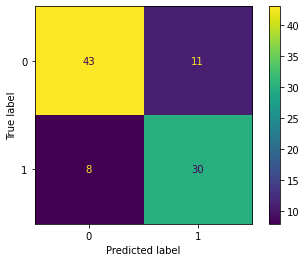

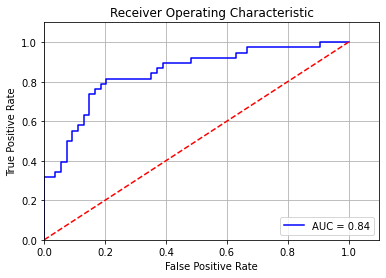

 F1 score on test set ----  0.7944492491548077
weighted roc auc on test set 0.8435672514619884
cross validation scores [0.6557265  0.83163597 0.70285714 0.68544892 0.73374296]
Specifity and sensitivity 0.7962962962962963 0.7894736842105263
29


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

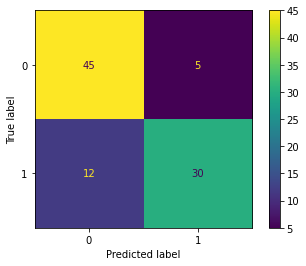

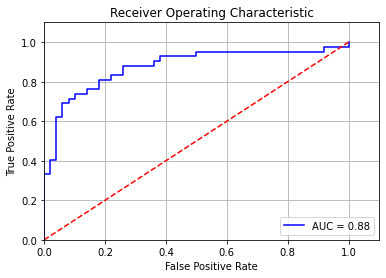

 F1 score on test set ----  0.8128624727568246
weighted roc auc on test set 0.8766666666666667
cross validation scores [0.75576049 0.74521842 0.76763299 0.67272727 0.79533228]
Specifity and sensitivity 0.9 0.7142857142857143
30


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

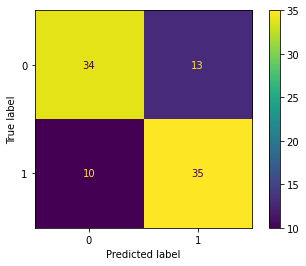

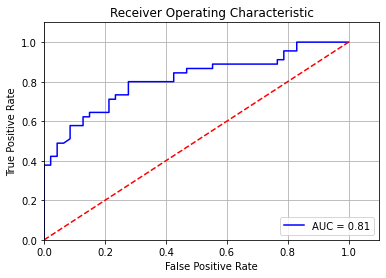

 F1 score on test set ----  0.7499113789436371
weighted roc auc on test set 0.8115839243498818
cross validation scores [0.77564921 0.79238095 0.72199883 0.76763299 0.67140152]
Specifity and sensitivity 0.723404255319149 0.7777777777777778
31


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

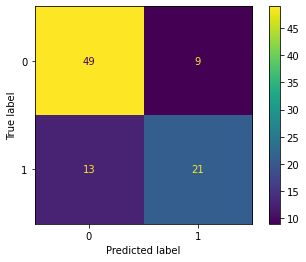

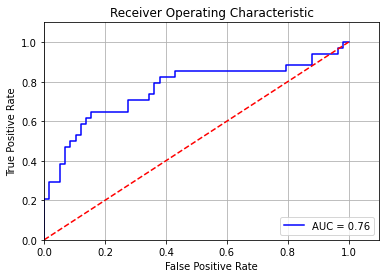

 F1 score on test set ----  0.7573822463768117
weighted roc auc on test set 0.7626774847870181
cross validation scores [0.77368421 0.75778785 0.75778785 0.71091515 0.77902447]
Specifity and sensitivity 0.8448275862068966 0.6176470588235294
32


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

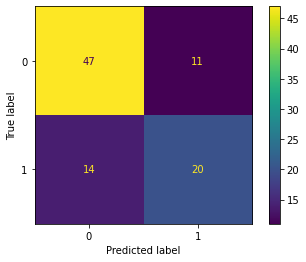

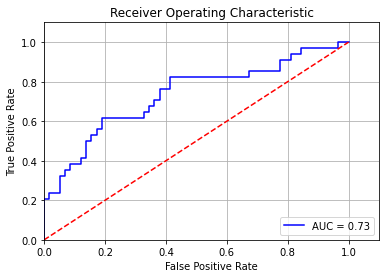

 F1 score on test set ----  0.725415249711925
weighted roc auc on test set 0.7342799188640974
cross validation scores [0.72052444 0.79931624 0.7162415  0.83393425 0.79061894]
Specifity and sensitivity 0.8103448275862069 0.5882352941176471
33


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

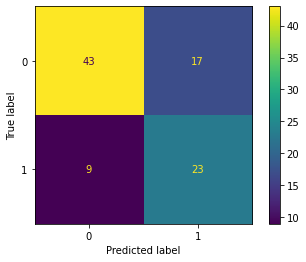

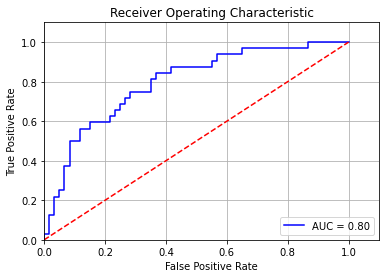

 F1 score on test set ----  0.7229986197377501
weighted roc auc on test set 0.7953125000000001
cross validation scores [0.73727273 0.66676853 0.70379424 0.83431889 0.69949989]
Specifity and sensitivity 0.7166666666666667 0.71875
34


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.6s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

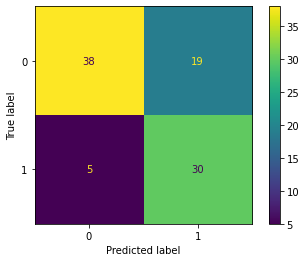

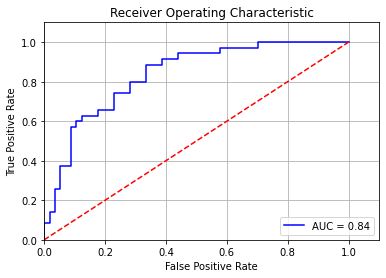

 F1 score on test set ----  0.7426086956521738
weighted roc auc on test set 0.8355889724310777
cross validation scores [0.73596491 0.76936937 0.7494598  0.68326103 0.6090535 ]
Specifity and sensitivity 0.6666666666666666 0.8571428571428571
35


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.6s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

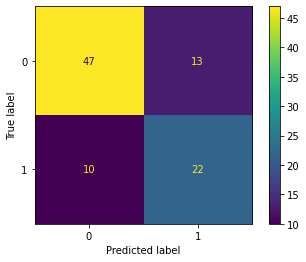

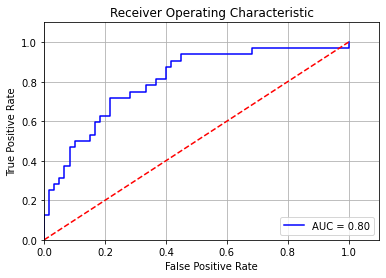

 F1 score on test set ----  0.7523918867202448
weighted roc auc on test set 0.8036458333333334
cross validation scores [0.74081996 0.75778785 0.74081996 0.7328017  0.76708438]
Specifity and sensitivity 0.7833333333333333 0.6875
36


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

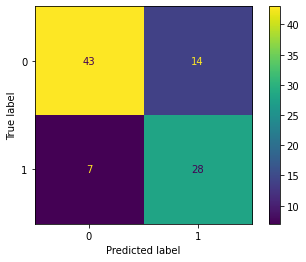

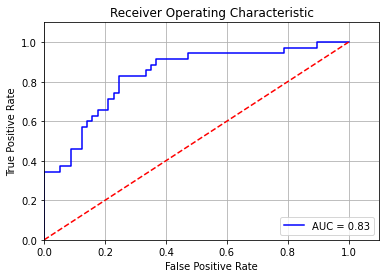

 F1 score on test set ----  0.774648147464076
weighted roc auc on test set 0.8320802005012531
cross validation scores [0.78628571 0.77368421 0.7162415  0.76625717 0.77962963]
Specifity and sensitivity 0.7543859649122807 0.8
37


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

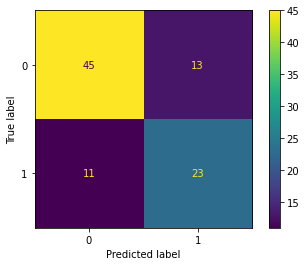

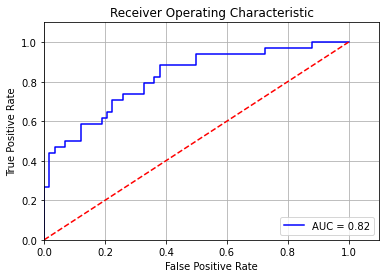

 F1 score on test set ----  0.7405688133376921
weighted roc auc on test set 0.8220081135902636
cross validation scores [0.76936937 0.73727273 0.73727273 0.64057257 0.83096712]
Specifity and sensitivity 0.7758620689655172 0.6764705882352942
38


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

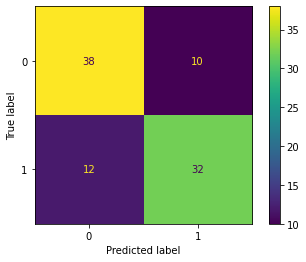

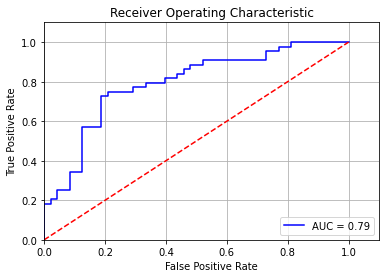

 F1 score on test set ----  0.7605290852438044
weighted roc auc on test set 0.7916666666666666
cross validation scores [0.81040131 0.76763299 0.76171329 0.78787879 0.73838229]
Specifity and sensitivity 0.7916666666666666 0.7272727272727273
39


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.5s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

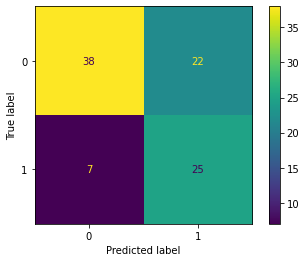

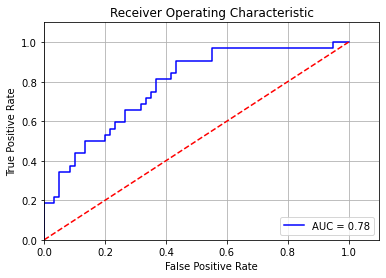

 F1 score on test set ----  0.6921927824514506
weighted roc auc on test set 0.7802083333333334
cross validation scores [0.79750087 0.77097289 0.74352617 0.6723705  0.84928652]
Specifity and sensitivity 0.6333333333333333 0.78125
40


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

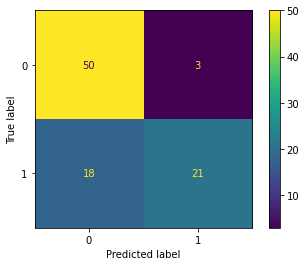

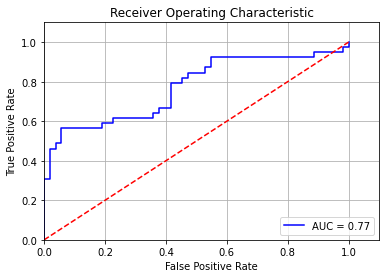

 F1 score on test set ----  0.7587136183974129
weighted roc auc on test set 0.7701983551040155
cross validation scores [0.72890515 0.76012725 0.68544892 0.8690502  0.73450292]
Specifity and sensitivity 0.9433962264150944 0.5384615384615384
41


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

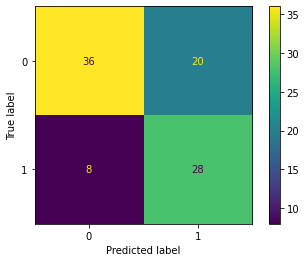

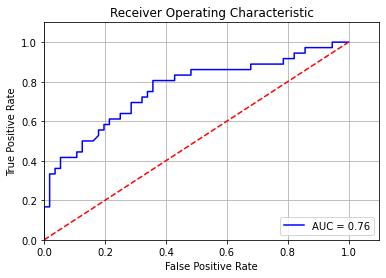

 F1 score on test set ----  0.6991304347826087
weighted roc auc on test set 0.7621527777777778
cross validation scores [0.62467532 0.86679008 0.77368421 0.83163597 0.76002352]
Specifity and sensitivity 0.6428571428571429 0.7777777777777778
42


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

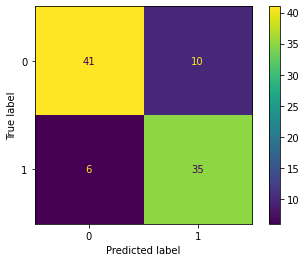

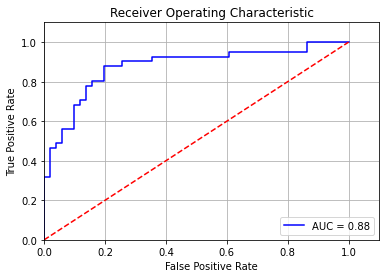

 F1 score on test set ----  0.8265822001196838
weighted roc auc on test set 0.8770923003347681
cross validation scores [0.7012987  0.70602125 0.77639553 0.65144948 0.75146978]
Specifity and sensitivity 0.803921568627451 0.8536585365853658
43


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

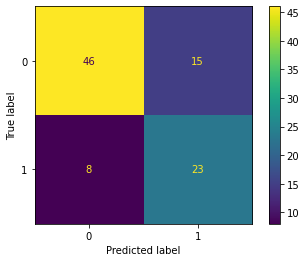

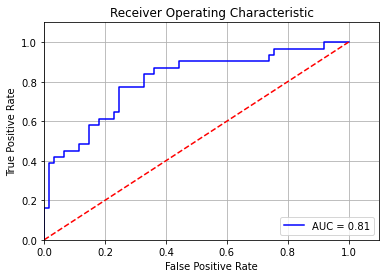

 F1 score on test set ----  0.755072463768116
weighted roc auc on test set 0.8053939714436806
cross validation scores [0.79191044 0.76068284 0.77784568 0.72447552 0.7452382 ]
Specifity and sensitivity 0.7540983606557377 0.7419354838709677
44


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

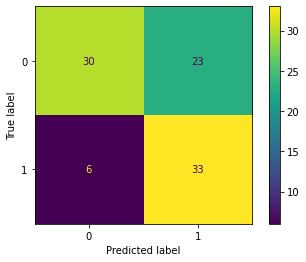

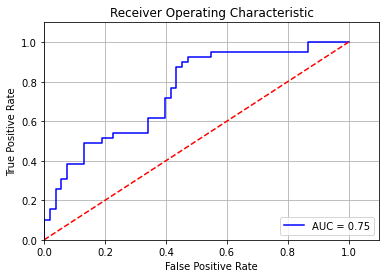

 F1 score on test set ----  0.6828812382690973
weighted roc auc on test set 0.7474600870827286
cross validation scores [0.66052632 0.82514286 0.76012725 0.79653304 0.84828739]
Specifity and sensitivity 0.5660377358490566 0.8461538461538461
45


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.7s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

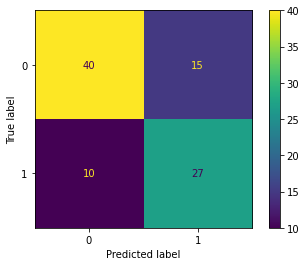

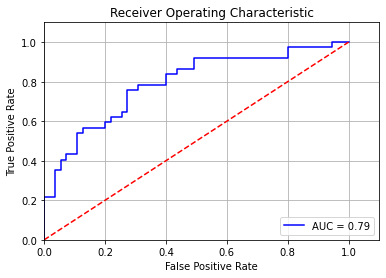

 F1 score on test set ----  0.7303902298398721
weighted roc auc on test set 0.7901719901719902
cross validation scores [0.70644258 0.81140351 0.69824561 0.76936937 0.76975773]
Specifity and sensitivity 0.7272727272727273 0.7297297297297297
46


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

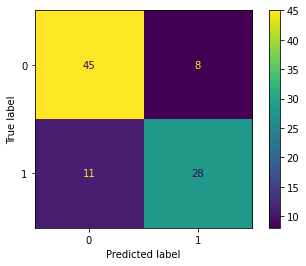

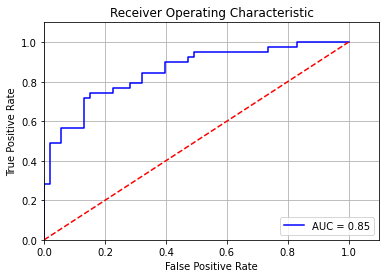

 F1 score on test set ----  0.7921898683685681
weighted roc auc on test set 0.8529269472665699
cross validation scores [0.78933333 0.69824561 0.67649019 0.66971429 0.77243108]
Specifity and sensitivity 0.8490566037735849 0.717948717948718
47


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.2s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

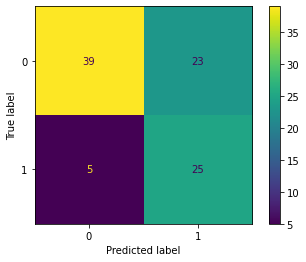

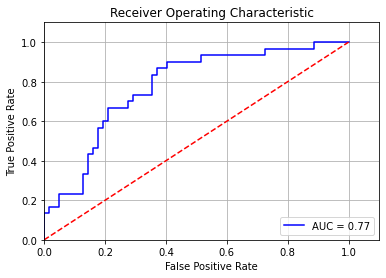

 F1 score on test set ----  0.7049283776109043
weighted roc auc on test set 0.7741935483870968
cross validation scores [0.6723705  0.77097289 0.83295573 0.78181818 0.72826511]
Specifity and sensitivity 0.6290322580645161 0.8333333333333334
48


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

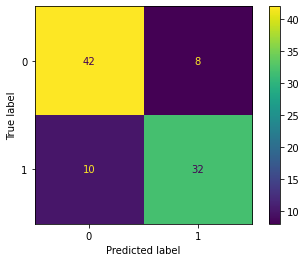

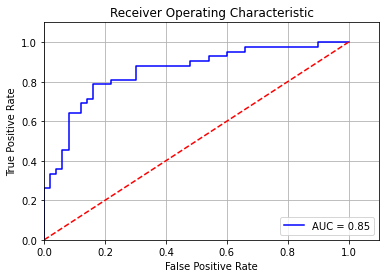

 F1 score on test set ----  0.8038799825338406
weighted roc auc on test set 0.8538095238095239
cross validation scores [0.69787297 0.73456183 0.81366295 0.72890515 0.81035923]
Specifity and sensitivity 0.84 0.7619047619047619
49


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

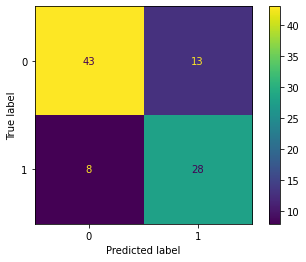

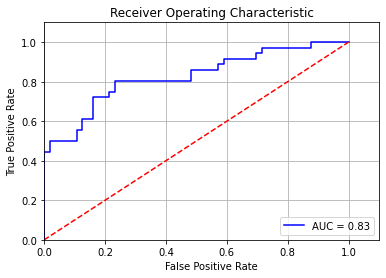

 F1 score on test set ----  0.7738169997414207
weighted roc auc on test set 0.8268849206349207
cross validation scores [0.73596491 0.71455017 0.73596491 0.7494598  0.77777778]
Specifity and sensitivity 0.7678571428571429 0.7777777777777778
50


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.5s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

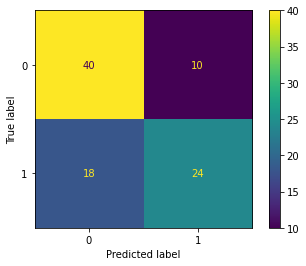

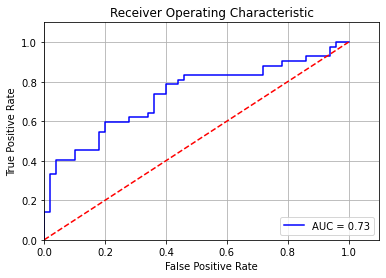

 F1 score on test set ----  0.6909060089838122
weighted roc auc on test set 0.7314285714285714
cross validation scores [0.73912812 0.81818182 0.7510303  0.72254506 0.80709877]
Specifity and sensitivity 0.8 0.5714285714285714
51


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.2s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

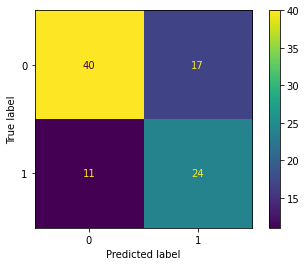

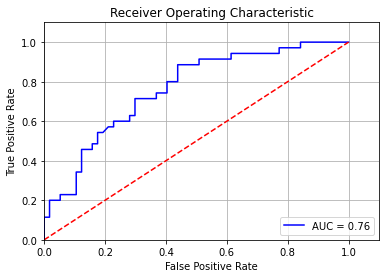

 F1 score on test set ----  0.6992117976099671
weighted roc auc on test set 0.7611528822055137
cross validation scores [0.59615385 0.76012725 0.77784568 0.79505125 0.81100218]
Specifity and sensitivity 0.7017543859649122 0.6857142857142857
52


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.5s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.6s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.6s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.6s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.6s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

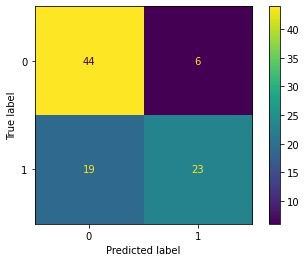

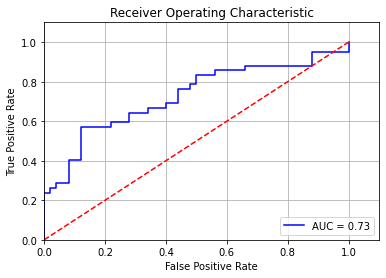

 F1 score on test set ----  0.7190143554671624
weighted roc auc on test set 0.7266666666666666
cross validation scores [0.7933358  0.81040131 0.7510303  0.7933358  0.7380719 ]
Specifity and sensitivity 0.88 0.5476190476190477
53


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.6s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.6s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.8s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.6s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

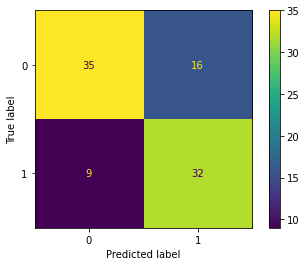

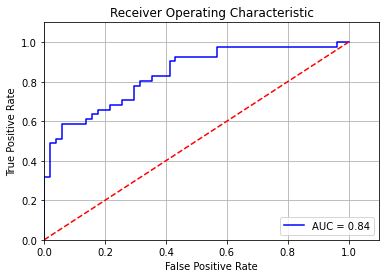

 F1 score on test set ----  0.728935798215617
weighted roc auc on test set 0.838833094213295
cross validation scores [0.83091111 0.75576049 0.73456183 0.67649019 0.74672755]
Specifity and sensitivity 0.6862745098039216 0.7804878048780488
54


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.5s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.6s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.8s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.7s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.6s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

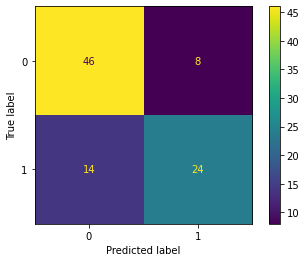

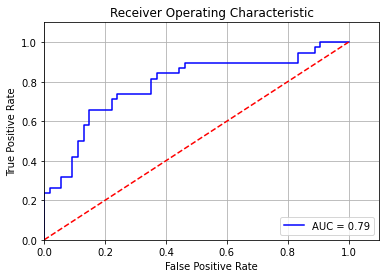

 F1 score on test set ----  0.756914024190912
weighted roc auc on test set 0.7855750487329435
cross validation scores [0.68962166 0.77714286 0.76408669 0.73093093 0.80709877]
Specifity and sensitivity 0.8518518518518519 0.631578947368421
55


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   6.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.0s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.0s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.6s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   5.0s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   7.1s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   6.8s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   6.1s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   6.8s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   6.6s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

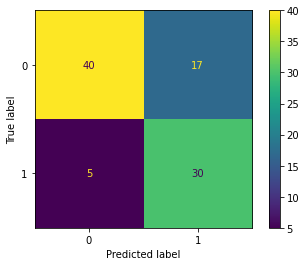

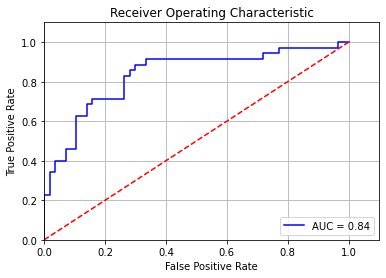

 F1 score on test set ----  0.7643004179402407
weighted roc auc on test set 0.8350877192982455
cross validation scores [0.78016529 0.6870468  0.74742857 0.83163597 0.70363122]
Specifity and sensitivity 0.7017543859649122 0.8571428571428571
56


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   6.3s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   6.6s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   6.1s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   6.8s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   6.7s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   6.9s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   6.6s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   6.7s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   6.2s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   6.7s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   6.7s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

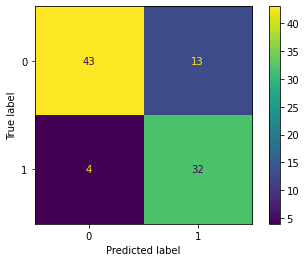

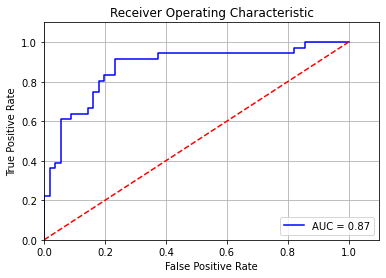

 F1 score on test set ----  0.8174100651939402
weighted roc auc on test set 0.8730158730158729
cross validation scores [0.71455017 0.73596491 0.75680751 0.72730003 0.75584139]
Specifity and sensitivity 0.7678571428571429 0.8888888888888888
57


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   3.8s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   3.9s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   3.8s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   3.8s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   3.7s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   3.8s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   3.8s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   3.8s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   3.8s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   3.8s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   3.8s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

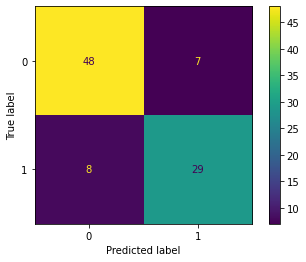

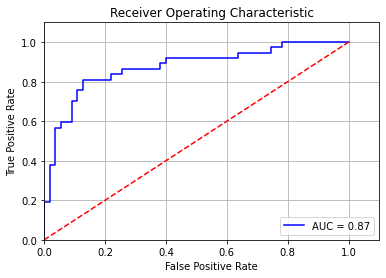

 F1 score on test set ----  0.8365742156689149
weighted roc auc on test set 0.8732186732186733
cross validation scores [0.69341439 0.7012987  0.69249249 0.67649019 0.72910363]
Specifity and sensitivity 0.8727272727272727 0.7837837837837838
58


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.5s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   5.1s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.1s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.4s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.0s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   3.9s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   3.9s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.1s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

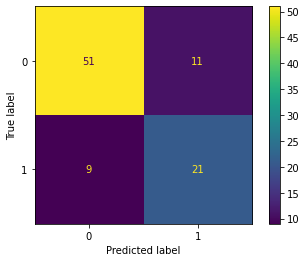

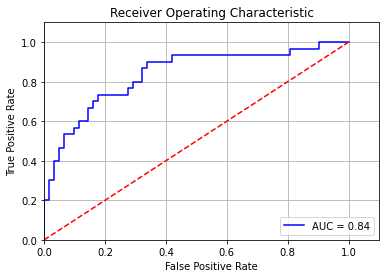

 F1 score on test set ----  0.7843331110753454
weighted roc auc on test set 0.8370967741935483
cross validation scores [0.72052444 0.7494598  0.7785124  0.74630303 0.76708438]
Specifity and sensitivity 0.8225806451612904 0.7
59


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   6.5s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   9.8s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   4.1s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.5s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.3s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   3.9s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   4.0s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   4.1s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

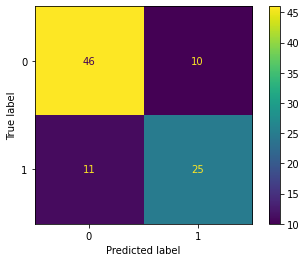

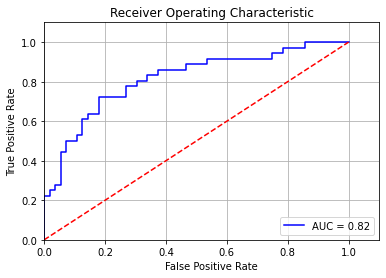

 F1 score on test set ----  0.7711416633699851
weighted roc auc on test set 0.8159722222222223
cross validation scores [0.75407597 0.74313725 0.73093093 0.6697479  0.7826629 ]
Specifity and sensitivity 0.8214285714285714 0.6944444444444444
60


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.7s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  11.0s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   9.1s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.6s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=  10.1s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.1s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=  10.2s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.7s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   8.3s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

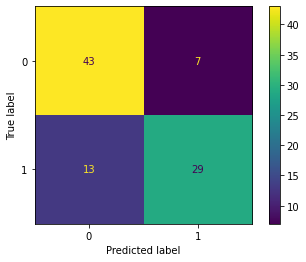

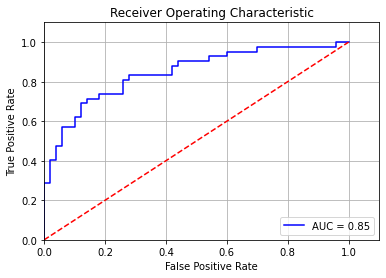

 F1 score on test set ----  0.7804000757241119
weighted roc auc on test set 0.8457142857142858
cross validation scores [0.65872236 0.68228438 0.69017731 0.79901025 0.763646  ]
Specifity and sensitivity 0.86 0.6904761904761905
61


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   7.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.8s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  11.1s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=  10.2s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.0s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.5s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.4s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.6s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   9.9s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

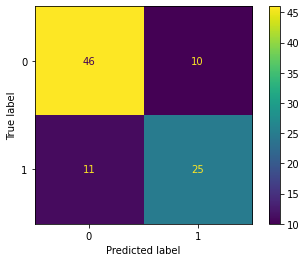

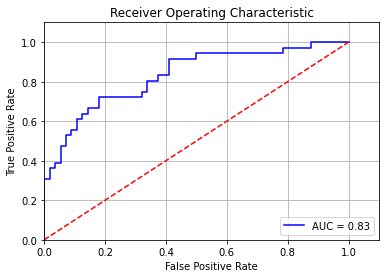

 F1 score on test set ----  0.7711416633699851
weighted roc auc on test set 0.8313492063492063
cross validation scores [0.77368421 0.79703075 0.74742857 0.72800958 0.71448037]
Specifity and sensitivity 0.8214285714285714 0.6944444444444444
62


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  10.6s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.9s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  10.3s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.4s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   9.7s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.8s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=  10.6s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=  10.0s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.7s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.0s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=  10.4s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

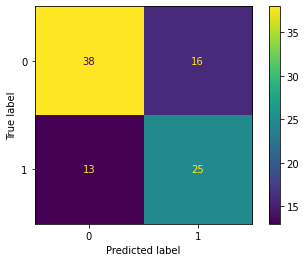

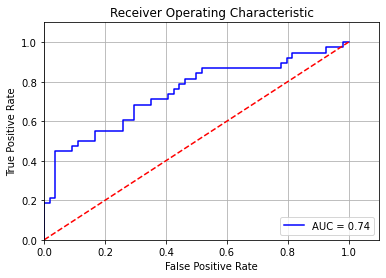

 F1 score on test set ----  0.6862646434468118
weighted roc auc on test set 0.7446393762183235
cross validation scores [0.74742857 0.69824561 0.75680751 0.85454545 0.83054627]
Specifity and sensitivity 0.7037037037037037 0.6578947368421053
63


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  10.4s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.7s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  11.4s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  11.5s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.4s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.0s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.9s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.2s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.1s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=  10.7s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

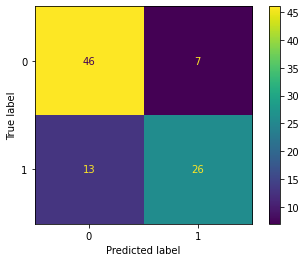

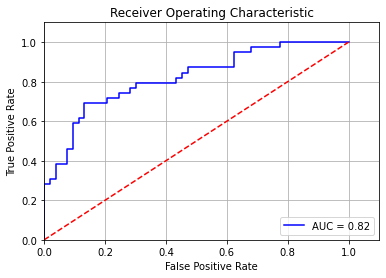

 F1 score on test set ----  0.7793737060041408
weighted roc auc on test set 0.8190614417029511
cross validation scores [0.7933358  0.63843021 0.73093093 0.81652661 0.73450292]
Specifity and sensitivity 0.8679245283018868 0.6666666666666666
64


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  11.2s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.9s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  10.7s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   9.3s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  10.7s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=  11.7s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.1s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=  10.7s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.7s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=   8.9s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

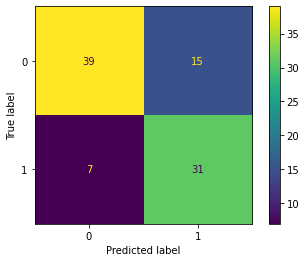

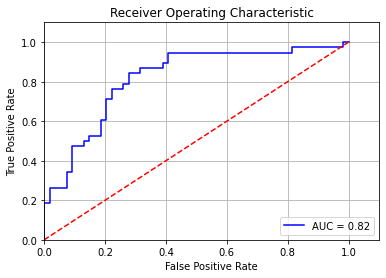

 F1 score on test set ----  0.7626915113871636
weighted roc auc on test set 0.8167641325536062
cross validation scores [0.79422174 0.76936937 0.69249249 0.72613676 0.75767544]
Specifity and sensitivity 0.7222222222222222 0.8157894736842105
65


/home/aditya/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.6s
[CV 2/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  10.3s
[CV 3/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   9.8s
[CV 4/5] END ................C=1e-05, gamma=1, kernel=linear; total time=   8.1s
[CV 5/5] END ................C=1e-05, gamma=1, kernel=linear; total time=  11.4s
[CV 1/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.3s
[CV 2/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=  10.2s
[CV 3/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   9.0s
[CV 4/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=  10.6s
[CV 5/5] END ..............C=1e-05, gamma=0.1, kernel=linear; total time=   8.2s
[CV 1/5] END .............C=1e-05, gamma=0.01, kernel=linear; total time=  10.9s
[CV 2/5] END .............C=1e-05, gamma=0.01, 

In [ ]:
clf_MCI = pd.DataFrame()
parent_dir = os.getcwd()

directory = 'WithBootStrapMCI'
path = os.path.join(parent_dir, directory)
os.mkdir(path)

for i in range(0,200):
    print(i)
    Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,2, i)
    clf = train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)
    dump(clf, path+'/MCI'+str(i)+'.joblib') 
    clf_MCI = clf_MCI.append(pd.DataFrame(clf.coef_))

In [ ]:
clf_AD = pd.DataFrame()

parent_dir = os.getcwd()

directory = 'WithBootStrapAD'
path = os.path.join(parent_dir, directory)
os.mkdir(path)

for i in range(0,200):
    Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,5, i)
    clf = train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)
    dump(clf, path+'/AD'+str(i)+'.joblib') 
    clf_AD = clf_AD.append(pd.DataFrame(clf.coef_))

In [ ]:
clf_MCI_mean = clf_MCI.mean()
clf_MCI_stddeviation = clf_MCI.std()
clf_MCI_Zmap = clf_MCI_mean.div(clf_MCI_stddeviation)

In [ ]:
import nibabel as nib
import numpy as np
from nilearn import plotting

mean_img = nib.load(mask).get_fdata()
afffine = nib.load(mask).affine
header = nib.load(mask).header

In [ ]:
stat_map = niftimasker.inverse_transform(clf_MCI_Zmap).get_data()
output = nib.Nifti1Image(stat_map, header=header, affine=afffine)

nib.save(output, path_MCI_visualization)
display = plotting.plot_stat_map(path_MCI_visualization, title='Raw z map CN_MCI')

In [ ]:
import nibabel as nib
import numpy as np
from nilearn import plotting

clf_AD_mean = clf_AD.mean()
clf_AD_stddeviation = clf_AD.std()
clf_AD_Zmap = clf_AD_mean.div(clf_AD_stddeviation)

mean_img = nib.load(mask).get_fdata()
#mean_img  = np.nan_to_num(mean_img)
afffine = nib.load(mask).affine

header = nib.load(mask).header

stat_map = niftimasker.inverse_transform(clf_AD_Zmap).get_data()
output = nib.Nifti1Image(stat_map, header=header, affine=afffine)
nib.save(output, path_AD_visualization)
display = plotting.plot_stat_map(path_AD_visualization, title='Raw z map clf_AD')